<a href="https://colab.research.google.com/github/8Raouf24/PFE/blob/master/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Voici le notebook contenant le code du Filtrage collaboratif . On essaye de deviner la note donné par des utilisateurs aux articles d'Amazon qu'ils n'ont pas notés . Voici les étapes qui seront suivis :


1.   Charger les données et les transformer en DataFrame
2.   Pré-traitement des données pour faciliter le training
3.   Création du réseaux de neuronnes 
4.   Training du réseaux de neuronnes
5.   Recommandation








In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
from keras.models import Sequential
from pathlib import Path
from sklearn.metrics import r2_score
import gzip
import matplotlib.pyplot as plt
import json
import math

Tout d'abord , nous téléchargons la base de données sur laquelle nous effectuerons nos travaux. Dans le cas échant nous utiliserons " Musical_Instruments_5" qui contient des articles d'Amazon appartenant a la catégorie " Instrument musical " ayant été noté par au moins 5  utilisateurs.

In [10]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz

--2020-10-26 20:10:16--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19408584 (19M) [application/octet-stream]
Saving to: ‘Digital_Music_5.json.gz’

Digital_Music_5.jso 100%[===================>]  18.51M  19.7MB/s    in 0.9s    

2020-10-26 20:10:18 (19.7 MB/s) - ‘Digital_Music_5.json.gz’ saved [19408584/19408584]



In [11]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Digital_Music.json.gz


--2020-10-26 20:10:27--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Digital_Music.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12164395 (12M) [application/octet-stream]
Saving to: ‘meta_Digital_Music.json.gz’

meta_Digital_Music. 100%[===================>]  11.60M  15.6MB/s    in 0.7s    

2020-10-26 20:10:28 (15.6 MB/s) - ‘meta_Digital_Music.json.gz’ saved [12164395/12164395]



Nous chargeons nos données depuis notre fichier json sous le format d'une liste afin de pouvoir faire la conversion vers un DataFrame.

In [12]:
#Chargement des données sous le format liste
def vectorise(path):
  liste = []
  with gzip.open(path) as f:
      for l in f:
          liste.append(json.loads(l.strip()))
  return liste
    
data = vectorise('Musical_Instruments_5.json.gz')
# Nombre total de produit
print(len(data))

# Un exemple de produit
print(data[0])

231392
{'overall': 5.0, 'verified': True, 'reviewTime': '10 30, 2016', 'reviewerID': 'A3FO5AKVTFRCRJ', 'asin': '0739079891', 'reviewerName': 'francisco', 'reviewText': "It's good for beginners", 'summary': 'Five Stars', 'unixReviewTime': 1477785600}


Une fois notre Dataframe crée , nous le filtrerons afin de récolter les données pertinantes pour notre systéme de recommandation , c'est à dire les utilisateurs , les articles , et les ratings.

In [13]:
#Transformation de nos données depuis le format liste vers le format dataframe
df = pd.DataFrame.from_dict(data)

data_dict = {'userID':df['reviewerID'],'itemID':df['asin'],'rating':df['overall']}
df_rs = pd.DataFrame.from_dict(data_dict)
df = df_rs

#Un exemple de ligne de notre dataframe
print(df_rs.iloc[0])

userID    A3FO5AKVTFRCRJ
itemID        0739079891
rating                 5
Name: 0, dtype: object


Ici , les prétraitements consisteront a transformer nos utilisateurs et nos articles en des indices d'entiers naturels.

In [14]:
#Tout d'abord , nous recuillons les users de facon unique dans une liste
user_ids = df_rs["userID"].unique().tolist()
#Nous représentons chaque utilisateur de notre liste en un nombre entier et vice versa
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

#Meme travail pour les articles
item_ids = df_rs["itemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}

#Nous remplacons les colonnes de notre DF contenant les ID des utilisateurs et des articles sous format caractères par le format encodé en  nombre entier
df_rs["user"] = df_rs["userID"].map(user2user_encoded)
df_rs["item"] = df_rs["itemID"].map(item2item_encoded)

#Nous récupérons la taille des vecteurs des utilisateurs et articles
num_users = len(user2user_encoded)
num_items = len(item_encoded2item)

#Nous covnertissions les notes du format int au format float
df_rs["rating"] = df_rs["rating"].values.astype(np.float32)

#Le min et le max seront utilisés pour la normalisation un peu plus tard
min_rating = min(df_rs["rating"])
max_rating = max(df_rs["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)


Number of users: 27530, Number of Items: 10620, Min rating: 1.0, Max rating: 5.0


Nous préparons notre training et validation set

In [15]:
#La fonction ci-dessous nous retourne une fraction de notre datafarme sous un ordre aléatoire
df_rs = df_rs.sample(frac=1, random_state=42)

#Nous définissons notre input ( liste de tuple user item)
x = df_rs[["user", "item"]].values
print(x)

# On normalise notre target (le rating) pour faciliter le training
y = df_rs["rating"].values#.apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# 70% du dataset sera utilisé pour le training et 30% pour la validation
train_indices = int(0.7 * df_rs.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


[[ 6178  4621]
 [ 3115  4673]
 [ 6455  3462]
 ...
 [18817  5460]
 [  369  6410]
 [ 2291  4979]]




Nous créeons notre modèle en vectorisant le vecteur d'un user et le vecteur d'un article en un seul vecteur de dimension 50.
Notre modèle calculera alors un score de correspondance  entre le vecteur de l'utilisateur et celui de l'article via un produit scalaire en ajoutant un biais par item et un biais par article . Le résultat sera entre un intervall de 0 et 1 via un sigmoid ( vu que nos ratings sont normalisés sur cette intervall)

In [ ]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

def recommandation_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the Keras functional API.
       Trained to discern if a link is present in on a book's page"""
    
    # Both inputs are 1-dimensional
    user = Input(name = 'user', shape = [1])
    item = Input(name = 'item', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    user_embedding = Embedding(name = 'User_Embedding',
                               input_dim = num_users,
                               output_dim = embedding_size,
                               embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6))(user)
    
    # Embedding the link (shape will be (None, 1, 50))
    item_embedding = Embedding(name = 'Item_Embedding',
                               input_dim = num_items,
                               output_dim = embedding_size,
                               embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6))(item)

    item_bias = layers.Embedding(name = 'Item_Bias',input_dim =num_items, output_dim =1)

    
    user_bias = layers.Embedding(name = 'User_Bias',input_dim = num_users,output_dim = 1)
    
    # Merge the layers with a dot product along the second axis 
    # (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, 
                 axes = 2)([user_embedding, item_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged) 
    
    # Squash outputs for classification
    out = Dense(1, activation = 'sigmoid')(merged)
    out = out + item_bias + user_bias
    model = Model(inputs = [book, link], outputs = out)
    
    # Compile using specified optimizer and loss 
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model


In [ ]:
model = recommandation_embedding_model()
model.summary()

ValueError: ignored

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        # nous ajoutons tout les composantes (y compris le biais)
        x = dot_user_item + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x





In [ ]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=False,
dpi=96,
)

NameError: ignored

In [ ]:
model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)


In [ ]:

#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])

es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)


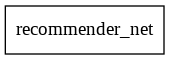

In [ ]:
#Schéma de notre RN
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=False,
dpi=96,
)

We train our model on the data split 

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)


Epoch 1/30
810/810 [==============================] - 12s 15ms/step - loss: 20.7948 - root_mean_squared_error: 4.5601 - mae: 4.4531 - val_loss: 20.5571 - val_root_mean_squared_error: 4.5340 - val_mae: 4.4266
Epoch 2/30
810/810 [==============================] - 12s 14ms/step - loss: 18.4996 - root_mean_squared_error: 4.3011 - mae: 4.1874 - val_loss: 19.2361 - val_root_mean_squared_error: 4.3859 - val_mae: 4.2748
Epoch 3/30
810/810 [==============================] - 12s 15ms/step - loss: 13.6861 - root_mean_squared_error: 3.6994 - mae: 3.5647 - val_loss: 15.4716 - val_root_mean_squared_error: 3.9333 - val_mae: 3.8069
Epoch 4/30
810/810 [==============================] - 12s 15ms/step - loss: 6.6852 - root_mean_squared_error: 2.5855 - mae: 2.4437 - val_loss: 10.1580 - val_root_mean_squared_error: 3.1871 - val_mae: 3.0456
Epoch 5/30
810/810 [==============================] - 12s 14ms/step - loss: 2.1684 - root_mean_squared_error: 1.4723 - mae: 1.3155 - val_loss: 6.8582 - val_root_mean_squ

PLot training , and validation rmse

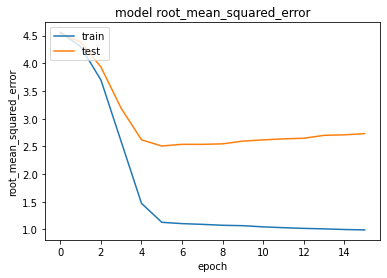

In [ ]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

source = "Building a Recommendation System Using Neural Network Embeddings" Will Kohersen

In [ ]:
model.save('/content/Keras_model/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/Keras_model/assets


In [ ]:
EMBEDDING_SIZE = 50

#Augmentation de la regularization des embeddings

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        # nous ajoutons tout les composantes (y compris le biais)
        x = dot_user_item + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x



model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)



history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)


plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


Epoch 1/100
627/810 [======================>.......] - ETA: 1s - loss: 20.8164 - root_mean_squared_error: 4.5615 - mae: 4.4545

KeyboardInterrupt: ignored

Epoch 1/100
810/810 [==============================] - 9s 11ms/step - loss: 19.8237 - root_mean_squared_error: 4.4510 - mae: 4.3402 - val_loss: 18.0031 - val_root_mean_squared_error: 4.2403 - val_mae: 4.1244
Epoch 2/100
810/810 [==============================] - 9s 11ms/step - loss: 15.3352 - root_mean_squared_error: 3.9099 - mae: 3.7697 - val_loss: 12.7413 - val_root_mean_squared_error: 3.5587 - val_mae: 3.3964
Epoch 3/100
810/810 [==============================] - 9s 11ms/step - loss: 10.1341 - root_mean_squared_error: 3.1656 - mae: 2.9559 - val_loss: 8.2370 - val_root_mean_squared_error: 2.8435 - val_mae: 2.5910
Epoch 4/100
810/810 [==============================] - 9s 11ms/step - loss: 6.3929 - root_mean_squared_error: 2.4907 - mae: 2.2068 - val_loss: 5.4372 - val_root_mean_squared_error: 2.2827 - val_mae: 1.9766
Epoch 5/100
810/810 [==============================] - 9s 11ms/step - loss: 4.1755 - root_mean_squared_error: 1.9787 - mae: 1.6744 - val_loss: 3.8107 - val_root_mean_squar

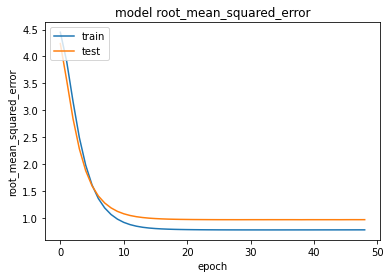

In [16]:
EMBEDDING_SIZE = 50

#Ajout d'un dense layer supplémentaire de taille 64

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)
        self.dense1 = layers.Dense(64)

    def call(self, inputs):

        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        x = tf.keras.layers.concatenate([user_vector,item_vector])
        x = self.dense1(x)

                              

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        

        # nous ajoutons tout les composantes (y compris le biais)
        x = x + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x



model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)

print(model.summary())

plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
model.save('.')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
EMBEDDING_SIZE = 50

#AJout d'un layer de taille 64 ainsi que d'un drop out

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)
        self.dense1 = layers.Dense(64)
        

    def call(self, inputs):

        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        x = tf.keras.layers.concatenate([user_vector,item_vector])
        x = self.dense1(x)
        x = layers.Dropout(0.1)(x)


                              

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        

        # nous ajoutons tout les composantes (y compris le biais)
        x = x + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x



model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mse"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

#Schéma de notre RN
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=False,
dpi=96,
)




list_result = []


In [ ]:
EMBEDDING_SIZE = 50

#AJout d'un layer de taille 64 ainsi que d'un drop out

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-5),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-5),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)
        self.dense1 = layers.Dense(64,activation='relu')
        
        
        

    def call(self, inputs):

        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        x = tf.keras.layers.concatenate([user_vector,item_vector])
        x = self.dense1(x)
       
        x = layers.Dropout(0.4)(x)


                              

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        

        # nous ajoutons tout les composantes (y compris le biais)
        x = x + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x



model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-3),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mse"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

#Schéma de notre RN
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=False,
dpi=96,
)




list_result = []


Epoch 1/300
648/648 [==============================] - 5s 8ms/step - loss: 12.5912 - root_mean_squared_error: 3.5303 - mse: 12.4632 - val_loss: 4.9652 - val_root_mean_squared_error: 2.1733 - val_mse: 4.7232
Epoch 2/300
648/648 [==============================] - 5s 7ms/step - loss: 8.4767 - root_mean_squared_error: 2.8674 - mse: 8.2221 - val_loss: 4.2893 - val_root_mean_squared_error: 2.0074 - val_mse: 4.0295
Epoch 3/300
648/648 [==============================] - 5s 7ms/step - loss: 7.7982 - root_mean_squared_error: 2.7479 - mse: 7.5512 - val_loss: 3.9552 - val_root_mean_squared_error: 1.9281 - val_mse: 3.7176
Epoch 4/300
648/648 [==============================] - 5s 7ms/step - loss: 7.2031 - root_mean_squared_error: 2.6422 - mse: 6.9811 - val_loss: 3.6690 - val_root_mean_squared_error: 1.8596 - val_mse: 3.4580
Epoch 5/300
648/648 [==============================] - 5s 7ms/step - loss: 6.6474 - root_mean_squared_error: 2.5398 - mse: 6.4505 - val_loss: 3.4322 - val_root_mean_squared_error

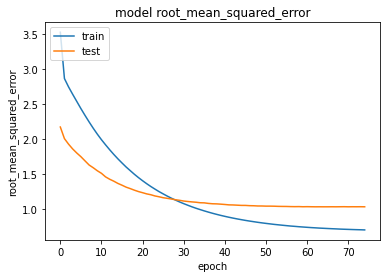

In [ ]:
history = model.fit(
    x=x_train[train_index],
    y=y_train[train_index],
    batch_size=200,
    epochs=300,
    verbose=1,
    validation_data=(x_train[test_index], y_train[test_index]),
    callbacks=[es],
    )

plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show() 

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
         metrics=[tf.keras.metrics.RootMeanSquaredError(),"mse"])
    es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

    history = model.fit(
    x=x_train[train_index],
    y=y_train[train_index],
    batch_size=200,
    epochs=300,
    verbose=1,
    validation_data=(x_train[test_index], y_train[test_index]),
    callbacks=[es],
    )

    plt.plot(history.history["root_mean_squared_error"])
    plt.plot(history.history["val_root_mean_squared_error"])
    plt.title("model root_mean_squared_error")
    plt.ylabel("root_mean_squared_error")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show() 


TRAIN: [ 32395  32396  32397 ... 161971 161972 161973] TEST: [    0     1     2 ... 32392 32393 32394]
Epoch 1/300
648/648 [==============================] - 5s 7ms/step - loss: 16.2469 - root_mean_squared_error: 4.0293 - mse: 16.2350 - val_loss: 7.5753 - val_root_mean_squared_error: 2.7490 - val_mse: 7.5568
Epoch 2/300
648/648 [==============================] - 5s 7ms/step - loss: 4.7032 - root_mean_squared_error: 2.1626 - mse: 4.6769 - val_loss: 2.0228 - val_root_mean_squared_error: 1.4112 - val_mse: 1.9914
Epoch 3/300
648/648 [==============================] - 5s 7ms/step - loss: 3.0689 - root_mean_squared_error: 1.7422 - mse: 3.0351 - val_loss: 1.4698 - val_root_mean_squared_error: 1.1976 - val_mse: 1.4342
Epoch 4/300
648/648 [==============================] - 5s 7ms/step - loss: 2.7943 - root_mean_squared_error: 1.6605 - mse: 2.7573 - val_loss: 1.3099 - val_root_mean_squared_error: 1.1277 - val_mse: 1.2716
Epoch 5/300
469/648 [====================>.........] - ETA: 1s - loss: 2.68

KeyboardInterrupt: ignored

Epoch 1/300
810/810 [==============================] - 16s 20ms/step - loss: 1.0563 - root_mean_squared_error: 1.0212 - mse: 1.0429 - val_loss: 1.0186 - val_root_mean_squared_error: 1.0028 - val_mse: 1.0055
Epoch 2/300
810/810 [==============================] - 13s 16ms/step - loss: 1.0385 - root_mean_squared_error: 1.0126 - mse: 1.0254 - val_loss: 1.0071 - val_root_mean_squared_error: 0.9970 - val_mse: 0.9941
Epoch 3/300
810/810 [==============================] - 13s 16ms/step - loss: 1.0275 - root_mean_squared_error: 1.0072 - mse: 1.0145 - val_loss: 0.9986 - val_root_mean_squared_error: 0.9928 - val_mse: 0.9857
Epoch 4/300
810/810 [==============================] - 13s 16ms/step - loss: 1.0210 - root_mean_squared_error: 1.0040 - mse: 1.0080 - val_loss: 0.9922 - val_root_mean_squared_error: 0.9895 - val_mse: 0.9792
Epoch 5/300
810/810 [==============================] - 13s 16ms/step - loss: 1.0141 - root_mean_squared_error: 1.0005 - mse: 1.0011 - val_loss: 0.9878 - val_root_mean_squar

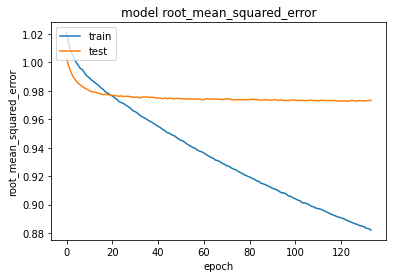

In [ ]:
  
history = model.fit(
      x=x_train,
    y=y_train,
    batch_size=200,
    epochs=300,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)




plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
list_result.mean

AttributeError: ignored

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
model.save('.')

In [17]:
meta_data = vectorise('meta_Musical_Instruments.json.gz')
# Nombre total de produit
print(len(meta_data))

# Un exemple de produit



120310


In [18]:
item_df = pd.DataFrame.from_dict(meta_data)
print(item_df.columns)
item_df.rename(columns = {'asin':'itemID'}, inplace = True)
print("\nafter modifications : \n",item_df.columns)


Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'image',
       'tech2', 'brand', 'feature', 'rank', 'also_view', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'details'],
      dtype='object')

after modifications : 
 Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'image',
       'tech2', 'brand', 'feature', 'rank', 'also_view', 'main_cat',
       'similar_item', 'date', 'price', 'itemID', 'details'],
      dtype='object')


In [ ]:
print(df_rs.info())

Giving top 10 recommandations article for musical instruments :

In [41]:
 import urllib.request
 from PIL import Image

In [46]:
def recommandation():
  user_id = df_rs.userID.sample(1).iloc[0]
  items_reviewed_by_user = df_rs[df_rs.userID == user_id]
  items_not_reviewed = item_df[
      ~item_df["itemID"].isin(items_reviewed_by_user.itemID.values)
  ]["itemID"]
  items_not_reviewed = list(set(items_not_reviewed).intersection(set(item2item_encoded.keys())))
  items_not_reviewed = [[item2item_encoded.get(x)] for x in items_not_reviewed]
  user_encoder = user2user_encoded.get(user_id)
  user_item_array = np.hstack(
    ([[user_encoder]] * len(items_not_reviewed), items_not_reviewed)
  )
  ratings = model.predict(user_item_array).flatten()
  rating_item = list(zip(items_not_reviewed,ratings))
  sorted_by_second = sorted(rating_item, key=lambda tup: tup[1])
  top_10 = sorted_by_second[-10:-1]
  res = [[ i for i, j in top_10 ], 
       [ j for i, j in top_10 ]] 
  top_10_indices = res[0]
  top_ratings_indices = []
  for i in top_10_indices:
    top_ratings_indices.append(i[0])
  recommended_item_ids = [
    item_encoded2item.get(items_not_reviewed[x][0]) for x in top_ratings_indices
  ]
  print("Showing recommendations for user: {}".format(user_id))
  print("====" * 9)
  print("Articles with high ratings from user")
  print("----" * 8)
  top_items_user = (
     items_reviewed_by_user.sort_values(by="rating", ascending=False)
      .head(5)
      .itemID.values
  )
  item_df_rows = item_df[item_df["itemID"].isin(top_items_user)]
  for row in item_df_rows.itertuples():
    print(row.title, ":", row.category)
  print("----" * 8)
  print("Top 10 articles recommendations")
  print("----" * 8)
  recommended_items = item_df[item_df["itemID"].isin(recommended_item_ids)]
  for row in recommended_items.itertuples():
    print(row.title, ":", row.category)
    if "image" in row :
      picture = Image.open(urllib.request.urlopen(row.image[0]))
      plt.figure()
      plt.imshow(picture)
      plt.title(row['title'])


In [47]:
recommandation()


Showing recommendations for user: A19NS4X2JZBSWB
Articles with high ratings from user
--------------------------------
Fender Pickguard Screws : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Electric Guitar Parts', 'Hardware']
Fender Pickguard Screws : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Electric Guitar Parts', 'Hardware']
Behringer VD400 Vintage Analog Delay Effects Pedal : ['Musical Instruments', 'Amplifiers & Effects', 'Guitar Effects', 'Electric Guitar Effects', 'Single Effects', 'Delay & Reverb']
YMC Pickguard-Loaded-Strat New Electric Guitar Pickguard Pick Guard 3 Single Coil Shell Loaded Prewired, Black : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Electric Guitar Parts', 'Pick Guards']
International Measurement Standard String Action Ruler Gauge Guitar Luthier Tool (Style 1) : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories']
YMC Premium

In [49]:
import urllib.request
from PIL import Image
url = 'http://ecx.images-amazon.com/images/I/51fAmVkTbyL._SY300_.jpg'
image = Image.open(urllib.request.urlopen(url))
width, height = image.size
print (width,height)

300 300


In [ ]:

print(user_item_array)

In [ ]:
ratings = model.predict(user_item_array).flatten()
print(ratings)
rating_item = list(zip(items_not_reviewed,ratings))
rating_item




In [27]:

print(top_10_indices)

[[2421], [7266], [9626], [8135], [2145], [7105], [1940], [3962], [9437]]
